<a href="https://colab.research.google.com/github/ayyucedemirbas/proteins_n_enzymes/blob/main/classify_proteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [4]:
torch.manual_seed(42)

In [5]:
dataset = TUDataset(root='./data/PROTEINS', name='PROTEINS', transform=OneHotDegree(100))

Processing...
Done!


In [6]:
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

In [7]:
train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
dataset

PROTEINS(1113)

In [10]:
len(dataset)

1113

In [11]:
dataset.num_features

104

In [12]:
dataset.num_classes

2

In [13]:
sample_graph = dataset[0]

In [14]:
sample_graph.num_nodes

42

In [15]:
sample_graph.num_edges

162

In [16]:
sample_graph.x.shape

torch.Size([42, 104])

In [17]:
sample_graph.edge_index.shape

torch.Size([2, 162])

In [18]:
sample_graph.y.item()

0

In [19]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # First Graph Convolution Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Graph Convolution Layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Final classification layer
        x = self.lin(x)

        return x

In [20]:
model = GCN(in_channels=dataset.num_features,
            hidden_channels=64,
            out_channels=dataset.num_classes)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [22]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

In [23]:
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_graphs
    return correct / total

In [24]:
train_losses = []
val_accuracies = []
best_val_acc = 0
best_model_state = None

In [25]:
for epoch in range(100):
    loss = train()
    train_losses.append(loss)

    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch: 000, Loss: 0.6727, Train Acc: 0.6057, Val Acc: 0.5650
Epoch: 010, Loss: 0.5633, Train Acc: 0.7211, Val Acc: 0.6457
Epoch: 020, Loss: 0.5539, Train Acc: 0.7406, Val Acc: 0.6996
Epoch: 030, Loss: 0.5473, Train Acc: 0.7406, Val Acc: 0.6771
Epoch: 040, Loss: 0.5335, Train Acc: 0.7286, Val Acc: 0.7040
Epoch: 050, Loss: 0.5355, Train Acc: 0.7466, Val Acc: 0.6906
Epoch: 060, Loss: 0.5386, Train Acc: 0.7271, Val Acc: 0.6637
Epoch: 070, Loss: 0.5310, Train Acc: 0.7676, Val Acc: 0.7040
Epoch: 080, Loss: 0.5194, Train Acc: 0.7691, Val Acc: 0.7130
Epoch: 090, Loss: 0.5026, Train Acc: 0.7466, Val Acc: 0.6996


In [26]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [27]:
test_acc = evaluate(test_loader)

In [28]:
test_acc

0.6771300448430493

Text(0.5, 1.0, 'Training Loss')

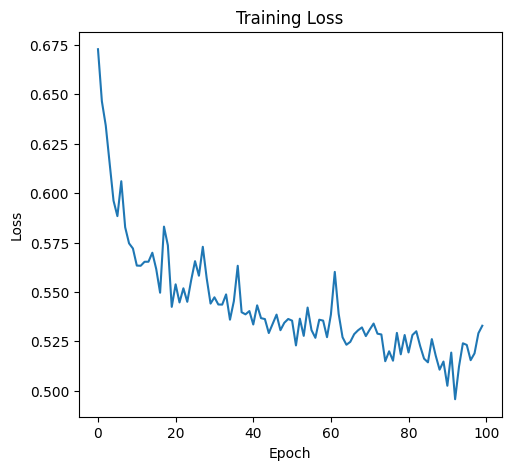

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

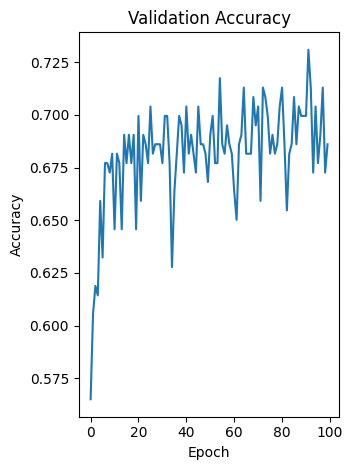

In [30]:
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.tight_layout()
plt.savefig('training_curves.png')

In [31]:
def visualize_embeddings():
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            # Get embeddings from the first layer
            x = model.conv1(data.x, data.edge_index)
            x = F.relu(x)

            # Pool node embeddings to get graph embeddings
            graph_embeddings = global_mean_pool(x, data.batch)

            all_embeddings.append(graph_embeddings.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())


    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.concatenate(all_labels)

    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    # Plot the embeddings colored by class
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=all_labels, cmap='tab10', s=50, alpha=0.8)
    plt.colorbar(scatter, ticks=range(dataset.num_classes),
                label='Class')
    plt.title('t-SNE visualization of graph embeddings')
    plt.savefig('graph_embeddings.png')

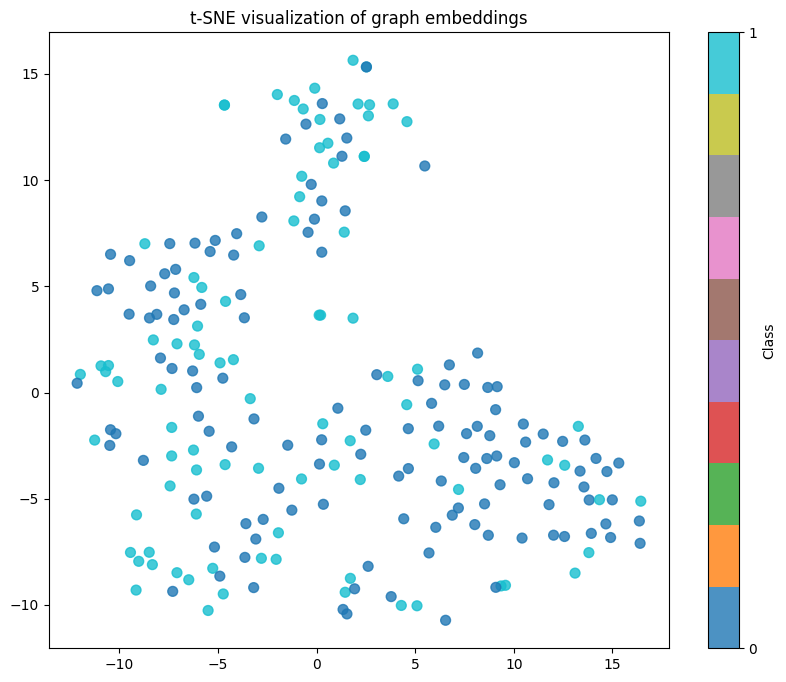

In [32]:
visualize_embeddings()

In [33]:
def predict_class(graph_data):
    model.eval()
    with torch.no_grad():
        # Create a batch with just one graph
        if not hasattr(graph_data, 'batch'):
            graph_data.batch = torch.zeros(graph_data.num_nodes, dtype=torch.long)

        # Forward pass through the model
        out = model(graph_data.x, graph_data.edge_index, graph_data.batch)
        pred = out.argmax(dim=1)

        return pred.item()

In [34]:
torch.save(model.state_dict(), 'gcn_protein_model.pt')

In [35]:
example_graph = dataset[0]

In [36]:
predicted_class = predict_class(example_graph)

In [37]:
actual_class = example_graph.y.item()

In [38]:
predicted_class

0

In [39]:
actual_class

0

In [40]:
model

GCN(
  (conv1): GCNConv(104, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)